In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold, StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, precision_recall_curve, auc, f1_score, cohen_kappa_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.feature_selection import RFE, SelectFromModel, RFECV
from xgboost import XGBClassifier, plot_importance, plot_tree

from IPython import display
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm

from pylab import rcParams

import os
import re
import time
import warnings
warnings.filterwarnings('ignore')

seed = 9001
np.random.seed(seed)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Read in processed extracted 6 hour window data training and test set

In [3]:
# training set
X_all = pd.read_csv('6hour_Xtrain.csv')
y_all = pd.read_csv('6hour_ytrain.csv')

# test set
X_test = pd.read_csv('6hour_Xtest.csv')
y_test = pd.read_csv('6hour_ytest.csv')

/content/drive/My Drive/sepsis


In [4]:
print(X_all.shape)
print(X_test.shape)

(1080424, 64)
(270106, 64)


### Define threshold that gives best F1-score

In [0]:
def performance2(y, y_pred, print_ = 1, *args):   
    """ Calculate performance measures for a given ground truth classification y and predicted 
    probabilities y_pred. If *args is provided a pre-defined threshold is used to calculate the performance.
    If not, the threshold giving the best mean sensitivity and specificity is selected. The AUC is calculated
    for a range of thresholds using the metrics package from sklearn. """

    # xx and yy values for ROC curve
    fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
    # area under the ROC curve
    AUC = auc(fpr, tpr)

    # xx and yy values for AUPR
    precision, recall, thresholds = precision_recall_curve(y, y_pred, pos_label=1)
    # convert to f1-score
    fscore = (2*precision*recall) / (precision+recall)
    fscore[np.isnan(fscore)] = 0

    # if a threshold is specified, use it
    if args:
        threshold = args[0]
    else:
    # if a threshold is not specified, we will choose the threshold that gives the best f1-score
        ix = np.argmax(fscore)
        threshold = thresholds[ix]        
        
    # transform the predicted probability into a binary classification
    y_pred[y_pred >= threshold] = 1
    y_pred[y_pred < threshold] = 0
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        
    # basic accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # for auc
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    
    # for f1-score
    precision1 = tp/(tp+fp)
    recall1 = sensitivity # detection rate
    
    # for false alarm rate
    fpr2 = fp/(fp+tn) # distinguish with false positive rate from calculating AUC
    fnr = fn/(fn+tp)
    
    # f1-score
    f1 = max(fscore)

    # kappa score
    kappa = cohen_kappa_score(y, y_pred)

    
    # print the performance and plot the ROC curve    
    if print_ == 1:
        print('Threshold: ' + str(round(threshold, 2)))
        print('TP: ' + str(tp))
        print('TN: ' + str(tn))
        print('FP: ' + str(fp))
        print('FN: ' + str(fn))
        
        print("Accuracy: " + str(round(accuracy, 2)))
        print('Sensitivity: ' + str(round(sensitivity, 2)))
        print('Specificity: ' + str(round(specificity, 2)))
        print('Precision: ' + str(round(precision1, 2)))
        print('Recall (Detection rate): ' + str(round(recall1, 2)))
        print('F1-score: ' + str(round(f1, 2)))
        print('AUC: ' + str(round(AUC, 2)))
        print('FPR (False alarm rate): ' + str(round(fpr2, 2)))
        print('FNR: ' + str(round(fnr, 2)))
        print('Kappa: ' + str(round(kappa, 2)))
    
        plt.figure(figsize = (4,3))
        plt.scatter(x = fpr, y = tpr, label = None)
        plt.plot(fpr, tpr, label = 'Classifier', zorder = 1)
        plt.plot([0, 1], [0, 1], 'k--', label = 'Random classifier')
        plt.scatter(x = 1 - specificity, y = sensitivity, c = 'black', label = 'Operating point', zorder = 2)
        plt.legend()
        plt.xlabel('1 - specificity')
        plt.ylabel('sensitivity')
        plt.show()
        

    return threshold, accuracy, sensitivity, specificity, AUC, precision1, recall1, f1, fpr2, fnr, kappa

### Create function to evaluate model performance on training and test set maximizing F1-score

In [0]:
def model_evaluation2(model, X_train, y_train, X_test, y_test, print_):
    
    # tune - parameter estimation 
    print('TRAINING SET')
    y_pred_prob_train = model.predict_proba(X_train)
    threshold, accuracy_tr, sensitivity_tr, specificity_tr, AUC_tr, precision_tr, \
    recall_tr, f1_tr, fpr_tr, fnr_tr, kappa_tr = performance2(y_train, np.delete(y_pred_prob_train, 0, 1), print_) # retain the probabilities of positive class only

    # test
    print('TEST SET')
    y_pred_prob_test = model.predict_proba(X_test)
    _, accuracy_test, sensitivity_test, specificity_test, AUC_test, precision_test, \
     recall_test, f1_test, fpr_test, fnr_test, kappa_test = performance2(y_test, np.delete(y_pred_prob_test, 0, 1), print_, threshold)
    
    # save the results
    results_train = pd.DataFrame(data = [[threshold, accuracy_tr, sensitivity_tr, specificity_tr, AUC_tr,
                                          precision_tr, recall_tr, f1_tr, fpr_tr, fnr_tr, kappa_tr, X_train.shape[1]]],
                                 columns = ['Threshold','Accuracy', 'Sensitivity', 'Specificity', 'AUROC',
                                            'Precision', 'Recall', 'F1', 'FPR (False Alarm)', 'FNR', 'Kappa', '# features'])

    results_test = pd.DataFrame(data = [[threshold, accuracy_test, sensitivity_test, specificity_test, AUC_test,
                                          precision_test, recall_test, f1_test, fpr_test, fnr_test, kappa_test, X_train.shape[1]]],
                                columns = ['Threshold','Accuracy', 'Sensitivity', 'Specificity', 'AUROC',
                                           'Precision', 'Recall', 'F1', 'FPR (False Alarm)', 'FNR', 'Kappa', '# features'])
        
    return results_train, results_test, y_pred_prob_train, y_pred_prob_test

### Create a stratified cv (to preserve class distribution during Cross-validation)

In [0]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# 50/50 Ratio

### Create balanced data using Random Undersampling

In [0]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=seed)

In [0]:
X_uds, y_uds = rus.fit_resample(X_all, y_all)

In [10]:
print('Sepsis patterns after Random Under-sampling:', np.count_nonzero(y_uds == 1))
print('Non-sepsis patterns after Random Under-sampling:', np.count_nonzero(y_uds == 0))

Sepsis patterns after Random Under-sampling: 20109
Non-sepsis patterns after Random Under-sampling: 20109


# 80/20 Ratio

In [0]:
ratio8020 = RandomUnderSampler(sampling_strategy=1/4, random_state=seed)

In [0]:
X_8020, y_8020 = ratio8020.fit_resample(X_all, y_all)

In [13]:
print('Sepsis patterns for 80/20 ratio:', np.count_nonzero(y_8020 == 1))
print('Non-sepsis patterns for 80/20 ratio:', np.count_nonzero(y_8020 == 0))

Sepsis patterns for 80/20 ratio: 20109
Non-sepsis patterns for 80/20 ratio: 80436


# 90/10 Ratio

In [0]:
ratio9010 = RandomUnderSampler(sampling_strategy=1/9, random_state=seed)

In [0]:
X_9010, y_9010 = ratio9010.fit_resample(X_all, y_all)

In [16]:
print('Sepsis patterns for 90/10 ratio:', np.count_nonzero(y_9010 == 1))
print('Non-sepsis patterns for 90/10 ratio:', np.count_nonzero(y_9010 == 0))

Sepsis patterns for 90/10 ratio: 20109
Non-sepsis patterns for 90/10 ratio: 180981


# 95/5 Ratio

In [0]:
ratio9505 = RandomUnderSampler(sampling_strategy=5/95, random_state=seed)

In [0]:
X_9505, y_9505 = ratio9505.fit_resample(X_all, y_all)

In [19]:
print('Sepsis patterns for 95/05 ratio:', np.count_nonzero(y_9505 == 1))
print('Non-sepsis patterns for 95/05 ratio:', np.count_nonzero(y_9505 == 0))

Sepsis patterns for 95/05 ratio: 20109
Non-sepsis patterns for 95/05 ratio: 382071


# 98/02: original dataset

In [20]:
print('Sepsis patterns for original ratio:', np.count_nonzero(y_all == 1))
print('Non-sepsis patterns for original ratio:', np.count_nonzero(y_all == 0))

Sepsis patterns for original ratio: 20109
Non-sepsis patterns for original ratio: 1060315


# 4. XGBoost

### Random Undersampling with All variables

In [0]:
# create the model/estimator
xgb_uds = XGBClassifier(booster='gbtree',
                        subsample=0.8,
                        colsample_bytree=0.8,
                        objective='binary:logistic',
                        nthread=-1,
                        seed=seed)

In [0]:
# create parameters grid to do GridSearch
learning_rate = [0.01, 0.05, 0.1, 0.3]
max_depth = [6, 8, 10]
min_child_weight = [1, 3, 5]
n_estimators = [100, 500, 1000]

In [0]:
param_xgb = dict(max_depth=max_depth,
                 min_child_weight=min_child_weight,
                 n_estimators=n_estimators,
                 learning_rate=learning_rate)

In [0]:
grid_xgb_uds = GridSearchCV(estimator=xgb_uds,
                            param_grid=param_xgb,
                            cv=kfold,
                            scoring='f1',
                            n_jobs=-1) # use all processors

In [25]:
start = datetime.now()

grid_xgb_uds.fit(X_uds, y_uds)

print('Training took: ', datetime.now()-start)

Training took:  1:16:21.163358


In [26]:
print('Best: %f using %s' % (grid_xgb_uds.best_score_, grid_xgb_uds.best_params_))

Best: 0.774854 using {'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 1000}


In [0]:
mean_f1 = grid_xgb_uds.cv_results_['mean_test_score']
std_f1 = grid_xgb_uds.cv_results_['std_test_score']
params = grid_xgb_uds.cv_results_['params']

In [28]:
for mean, stdev, param in zip(mean_f1, std_f1, params): # zip: create tuples of value pairs
    print('%f (+-%f) with: %r' % (mean, stdev, param))

0.650598 (+-0.009621) with: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100}
0.682607 (+-0.007583) with: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500}
0.695359 (+-0.007035) with: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 1000}
0.649571 (+-0.009776) with: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100}
0.681570 (+-0.007009) with: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500}
0.693638 (+-0.007488) with: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 1000}
0.649732 (+-0.009108) with: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100}
0.681135 (+-0.007876) with: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500}
0.693427 (+-0.006745) with: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimato

In [0]:
best_xgb_uds = grid_xgb_uds.best_estimator_

### Performance on training and test sets

TRAINING SET
Threshold: 0.75
TP: 20109
TN: 20107
FP: 2
FN: 0
Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall (Detection rate): 1.0
F1-score: 1.0
AUC: 1.0
FPR (False alarm rate): 0.0
FNR: 0.0
Kappa: 1.0


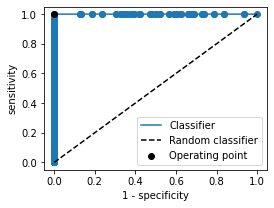

TEST SET
Threshold: 0.75
TP: 3140
TN: 232591
FP: 32488
FN: 1887
Accuracy: 0.87
Sensitivity: 0.62
Specificity: 0.88
Precision: 0.09
Recall (Detection rate): 0.62
F1-score: 0.2
AUC: 0.86
FPR (False alarm rate): 0.12
FNR: 0.38
Kappa: 0.13


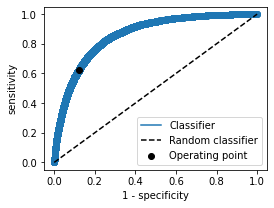

In [30]:
results_train_xgb_uds_all, results_test_xgb_uds_all, \
y_pred_prob_train_xgb_uds, y_pred_prob_test_xgb_uds = model_evaluation2(best_xgb_uds, 
                                                                        X_uds, y_uds,
                                                                        X_test.values, y_test.values,
                                                                        print_ = 1)

### Save results to dataframe

In [0]:
xgb_results_train = pd.DataFrame()
xgb_results_test = pd.DataFrame()

In [0]:
xgb_results_train = xgb_results_train.append(results_train_xgb_uds_all.rename(index={results_train_xgb_uds_all.index[-1]: 'XGB 50/50 Ratio All features'}))
xgb_results_test = xgb_results_test.append(results_test_xgb_uds_all.rename(index={results_test_xgb_uds_all.index[-1]: 'XGB 50/50 Ratio All features'}))

### Random Under-sampling with Feature selection by Recursive Feature Elimination (RFE)

In [37]:
grid_xgb_uds.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 1000}

In [0]:
xgb_uds_fs = RFECV(estimator=best_xgb_uds, step=1, cv=kfold, scoring='f1', n_jobs=-1)

In [38]:
start = datetime.now()

xgb_uds_fs.fit(X_uds, y_uds)

print('Training took: ', datetime.now()-start)

Training took:  2:44:53.418835


### Optimal Number of features

In [39]:
print('Optimal number of features: {}'.format(xgb_uds_fs.n_features_))

Optimal number of features: 22


### Plot the optimal number of features against F1-score

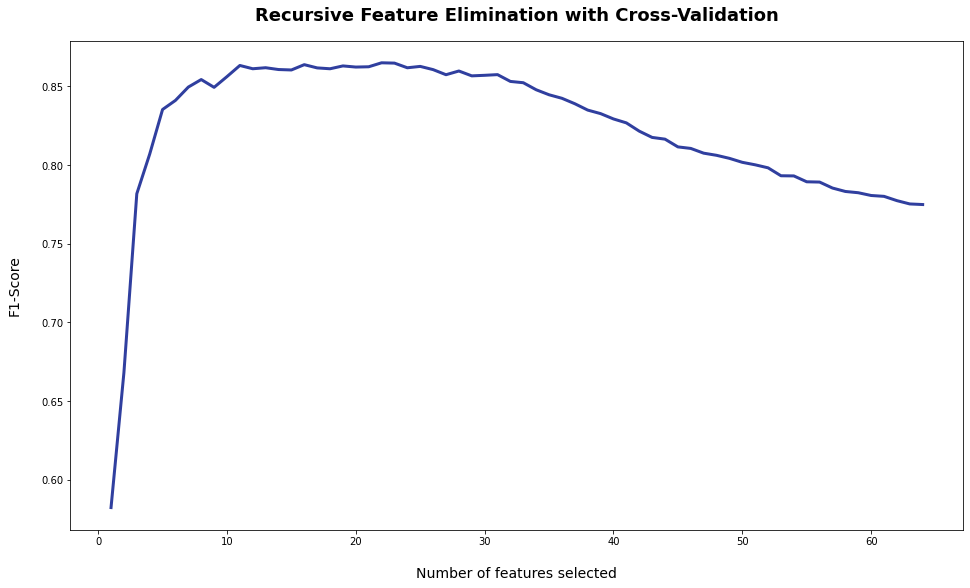

In [40]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('F1-Score', fontsize=14, labelpad=20)
plt.plot(range(1, len(xgb_uds_fs.grid_scores_) + 1), xgb_uds_fs.grid_scores_, color='#303F9F', linewidth=3)

### Now only select the important features according to the model

In [0]:
rfe_feat = xgb_uds_fs.support_

### Use these selected features for Random Undersample dataset

In [0]:
X_uds_rfe, y_uds_rfe = rus.fit_resample(X_all.loc[:, rfe_feat], y_all)

In [0]:
rfe_features = X_all.loc[:, rfe_feat].columns

In [44]:
rfe_features

Index(['Temp_diff3', 'DBP_std', 'Age', 'Temp_diff2', 'Temp_diff4', 'Resp_min',
       'Resp_mean', 'Temp_diff1', 'Temp_diff5', 'Resp_max', 'MAP_min',
       'O2Sat_min', 'SBP_min', 'DBP_min', 'MAP_max', 'DBP_max', 'HR_max',
       'Temp_max', 'Temp_min', 'SBP_max', 'HR_mean', 'O2Sat_max'],
      dtype='object')

### Model

In [47]:
start = datetime.now()

best_xgb_uds.fit(X_uds_rfe, y_uds_rfe)

print('Training took: ', datetime.now()-start)

Training took:  0:00:17.534663


### Feature importance determined by the model

Text(0.5, 0, 'Relative Importance')

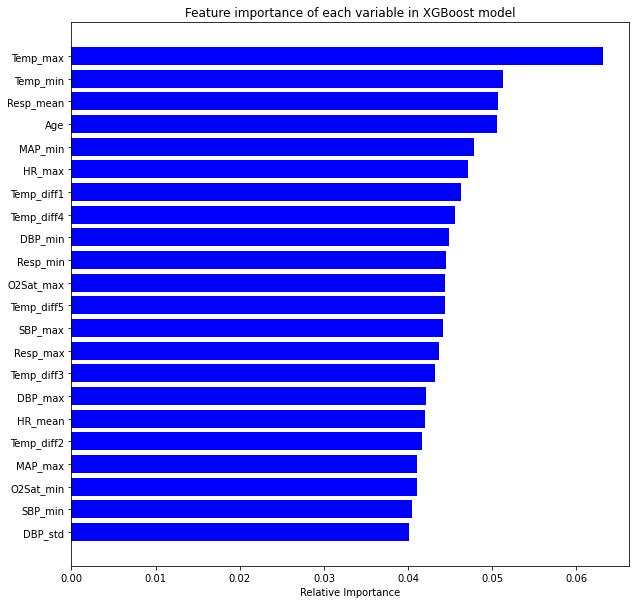

In [48]:
rcParams['figure.figsize'] = 10, 10
features = rfe_features
importances = best_xgb_uds.feature_importances_
indices = np.argsort(importances)

plt.title('Feature importance of each variable in XGBoost model')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

### Model Performance

TRAINING SET
Threshold: 0.74
TP: 20109
TN: 20107
FP: 2
FN: 0
Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall (Detection rate): 1.0
F1-score: 1.0
AUC: 1.0
FPR (False alarm rate): 0.0
FNR: 0.0
Kappa: 1.0


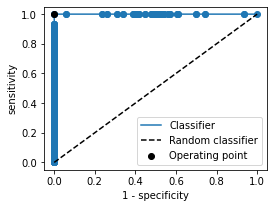

TEST SET
Threshold: 0.74
TP: 3982
TN: 243641
FP: 21438
FN: 1045
Accuracy: 0.92
Sensitivity: 0.79
Specificity: 0.92
Precision: 0.16
Recall (Detection rate): 0.79
F1-score: 0.38
AUC: 0.94
FPR (False alarm rate): 0.08
FNR: 0.21
Kappa: 0.24


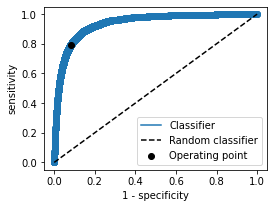

In [0]:
results_train_xgb_uds_rfe, results_test_xgb_uds_rfe, \
y_pred_prob_train_xgb_rfe, y_pred_prob_test_xgb_rfe = model_evaluation2(best_xgb_uds, 
                                                                        X_uds_rfe, y_uds_rfe,
                                                                        X_test.loc[:, rfe_feat].values, y_test.values,
                                                                        print_ = 1)

### Save results to dataframe

In [0]:
xgb_results_train = xgb_results_train.append(results_train_xgb_uds_rfe.rename(index={results_train_xgb_uds_rfe.index[-1]: 'XGB 50/50 Ratio with Feature selection'}))
xgb_results_test = xgb_results_test.append(results_test_xgb_uds_rfe.rename(index={results_test_xgb_uds_rfe.index[-1]: 'XGB 50/50 Ratio with Feature selection'}))

# 80/20 Ratio: All features

In [0]:
grid_xgb_uds.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 1000}

In [0]:
# create the model/estimator
xgb_8020 = XGBClassifier(booster='gbtree',
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective='binary:logistic',
                         nthread=-1,
                         seed=seed,
                         learning_rate=0.1,
                         max_depth=10,
                         min_child_weight=1,
                         n_estimators=1000)

In [0]:
start = datetime.now()

xgb_8020.fit(X_8020, y_8020)

print('Training took: ', datetime.now()-start)

Training took:  0:00:49.008179


### Performance on training and test set

TRAINING SET
Threshold: 0.3
TP: 20095
TN: 80425
FP: 11
FN: 14
Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall (Detection rate): 1.0
F1-score: 1.0
AUC: 1.0
FPR (False alarm rate): 0.0
FNR: 0.0
Kappa: 1.0


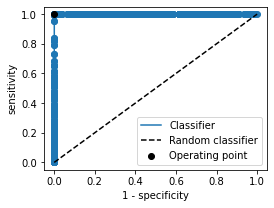

TEST SET
Threshold: 0.3
TP: 2945
TN: 247874
FP: 17205
FN: 2082
Accuracy: 0.93
Sensitivity: 0.59
Specificity: 0.94
Precision: 0.15
Recall (Detection rate): 0.59
F1-score: 0.29
AUC: 0.9
FPR (False alarm rate): 0.06
FNR: 0.41
Kappa: 0.21


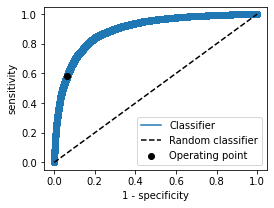

In [0]:
results_train_xgb_8020, results_test_xgb_8020, \
y_pred_prob_train_xgb_8020, y_pred_prob_test_xgb_8020 = model_evaluation2(xgb_8020, 
                                                                          X_8020, y_8020,
                                                                          X_test.values, y_test.values,
                                                                          print_ = 1)

### Save results to dataframe

In [0]:
xgb_results_train = xgb_results_train.append(results_train_xgb_8020.rename(index={results_train_xgb_8020.index[-1]: 'XGB 80/20 Ratio All features'}))
xgb_results_test = xgb_results_test.append(results_test_xgb_8020.rename(index={results_test_xgb_8020.index[-1]: 'XGB 80/20 Ratio All features'}))

# 80/20 Ratio: Feature selection

In [0]:
# create the model/estimator
xgb_8020_rfe = XGBClassifier(booster='gbtree',
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective='binary:logistic',
                             nthread=-1,
                             seed=seed,
                             learning_rate=0.1,
                             max_depth=10,
                             min_child_weight=1,
                             n_estimators=1000)

### Use the selected features for 80/20 dataset

In [0]:
X_8020_rfe, y_8020_rfe = ratio8020.fit_resample(X_all.loc[:, rfe_feat], y_all)

### Model

In [0]:
start = datetime.now()

xgb_8020_rfe.fit(X_8020_rfe, y_8020_rfe)

print('Training took: ', datetime.now()-start)

Training took:  0:00:39.198816


### Model Performance

TRAINING SET
Threshold: 0.41
TP: 20109
TN: 80432
FP: 4
FN: 0
Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall (Detection rate): 1.0
F1-score: 1.0
AUC: 1.0
FPR (False alarm rate): 0.0
FNR: 0.0
Kappa: 1.0


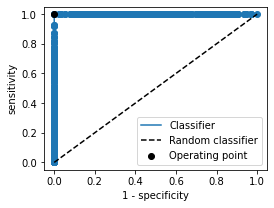

TEST SET
Threshold: 0.41
TP: 3835
TN: 259827
FP: 5252
FN: 1192
Accuracy: 0.98
Sensitivity: 0.76
Specificity: 0.98
Precision: 0.42
Recall (Detection rate): 0.76
F1-score: 0.62
AUC: 0.97
FPR (False alarm rate): 0.02
FNR: 0.24
Kappa: 0.53


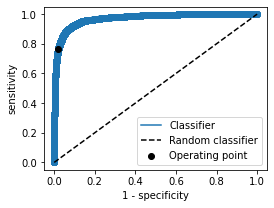

In [0]:
results_train_xgb_8020_rfe, results_test_xgb_8020_rfe, \
y_pred_prob_train_xgb_8020_rfe, y_pred_prob_test_xgb_8020_rfe = model_evaluation2(xgb_8020_rfe, 
                                                                                  X_8020_rfe, y_8020_rfe,
                                                                                  X_test.loc[:, rfe_feat].values, y_test.values,
                                                                                  print_ = 1)

### Save results to dataframe

In [0]:
xgb_results_train = xgb_results_train.append(results_train_xgb_8020_rfe.rename(index={results_train_xgb_8020_rfe.index[-1]: 'XGB 80/20 Ratio with Feature Selection'}))
xgb_results_test = xgb_results_test.append(results_test_xgb_8020_rfe.rename(index={results_test_xgb_8020_rfe.index[-1]: 'XGB 80/20 Ratio with Feature Selection'}))

# 90/10 Ratio: All features

In [0]:
grid_xgb_uds.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 1000}

In [0]:
# create the model/estimator
xgb_9010 = XGBClassifier(booster='gbtree',
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective='binary:logistic',
                         nthread=-1,
                         seed=seed,
                         learning_rate=0.1,
                         max_depth=10,
                         min_child_weight=1,
                         n_estimators=1000)

In [0]:
start = datetime.now()

xgb_9010.fit(X_9010, y_9010)

print('Training took: ', datetime.now()-start)

Training took:  0:01:34.566193


### Performance on training and test set

TRAINING SET
Threshold: 0.24
TP: 19483
TN: 180643
FP: 338
FN: 626
Accuracy: 1.0
Sensitivity: 0.97
Specificity: 1.0
Precision: 0.98
Recall (Detection rate): 0.97
F1-score: 0.98
AUC: 1.0
FPR (False alarm rate): 0.0
FNR: 0.03
Kappa: 0.97


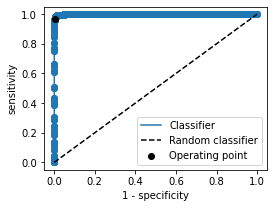

TEST SET
Threshold: 0.24
TP: 2312
TN: 258016
FP: 7063
FN: 2715
Accuracy: 0.96
Sensitivity: 0.46
Specificity: 0.97
Precision: 0.25
Recall (Detection rate): 0.46
F1-score: 0.34
AUC: 0.9
FPR (False alarm rate): 0.03
FNR: 0.54
Kappa: 0.3


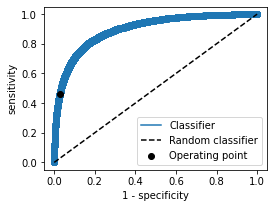

In [0]:
results_train_xgb_9010, results_test_xgb_9010, \
y_pred_prob_train_xgb_9010, y_pred_prob_test_xgb_9010 = model_evaluation2(xgb_9010, 
                                                                          X_9010, y_9010,
                                                                          X_test.values, y_test.values,
                                                                          print_ = 1)

### Save results to dataframe

In [0]:
xgb_results_train = xgb_results_train.append(results_train_xgb_9010.rename(index={results_train_xgb_9010.index[-1]: 'XGB 90/10 Ratio All features'}))
xgb_results_test = xgb_results_test.append(results_test_xgb_9010.rename(index={results_test_xgb_9010.index[-1]: 'XGB 90/10 Ratio All features'}))

# 90/10 Ratio: Feature selection

In [0]:
# create the model/estimator
xgb_9010_rfe = XGBClassifier(booster='gbtree',
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective='binary:logistic',
                             nthread=-1,
                             seed=seed,
                             learning_rate=0.1,
                             max_depth=10,
                             min_child_weight=1,
                             n_estimators=1000)

### Use the selected features for 90/10 dataset

In [0]:
X_9010_rfe, y_9010_rfe = ratio9010.fit_resample(X_all.loc[:, rfe_feat], y_all)

### Model

In [0]:
start = datetime.now()

xgb_9010_rfe.fit(X_9010_rfe, y_9010_rfe)

print('Training took: ', datetime.now()-start)

Training took:  0:01:16.543656


### Model Performance

TRAINING SET
Threshold: 0.34
TP: 20107
TN: 180973
FP: 8
FN: 2
Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall (Detection rate): 1.0
F1-score: 1.0
AUC: 1.0
FPR (False alarm rate): 0.0
FNR: 0.0
Kappa: 1.0


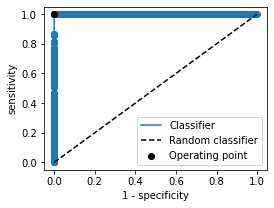

TEST SET
Threshold: 0.34
TP: 3483
TN: 263826
FP: 1253
FN: 1544
Accuracy: 0.99
Sensitivity: 0.69
Specificity: 1.0
Precision: 0.74
Recall (Detection rate): 0.69
F1-score: 0.72
AUC: 0.98
FPR (False alarm rate): 0.0
FNR: 0.31
Kappa: 0.71


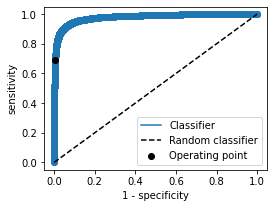

In [0]:
results_train_xgb_9010_rfe, results_test_xgb_9010_rfe, \
y_pred_prob_train_xgb_9010_rfe, y_pred_prob_test_xgb_9010_rfe = model_evaluation2(xgb_9010_rfe, 
                                                                                  X_9010_rfe, y_9010_rfe,
                                                                                  X_test.loc[:, rfe_feat].values, y_test.values,
                                                                                  print_ = 1)

### Save results to dataframe

In [0]:
xgb_results_train = xgb_results_train.append(results_train_xgb_9010_rfe.rename(index={results_train_xgb_9010_rfe.index[-1]: 'XGB 90/10 Ratio with Feature Selection'}))
xgb_results_test = xgb_results_test.append(results_test_xgb_9010_rfe.rename(index={results_test_xgb_9010_rfe.index[-1]: 'XGB 90/10 Ratio with Feature Selection'}))

# 95/05 Ratio: All features

In [0]:
grid_xgb_uds.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 1000}

In [0]:
# create the model/estimator
xgb_9505 = XGBClassifier(booster='gbtree',
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective='binary:logistic',
                         nthread=-1,
                         seed=seed,
                         learning_rate=0.1,
                         max_depth=10,
                         min_child_weight=1,
                         n_estimators=1000)

In [0]:
start = datetime.now()

xgb_9505.fit(X_9505, y_9505)

print('Training took: ', datetime.now()-start)

Training took:  0:03:16.341157


### Performance on training and test set

TRAINING SET
Threshold: 0.19
TP: 18769
TN: 381575
FP: 496
FN: 1340
Accuracy: 1.0
Sensitivity: 0.93
Specificity: 1.0
Precision: 0.97
Recall (Detection rate): 0.93
F1-score: 0.95
AUC: 1.0
FPR (False alarm rate): 0.0
FNR: 0.07
Kappa: 0.95


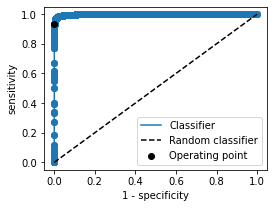

TEST SET
Threshold: 0.19
TP: 1821
TN: 262551
FP: 2528
FN: 3206
Accuracy: 0.98
Sensitivity: 0.36
Specificity: 0.99
Precision: 0.42
Recall (Detection rate): 0.36
F1-score: 0.39
AUC: 0.9
FPR (False alarm rate): 0.01
FNR: 0.64
Kappa: 0.38


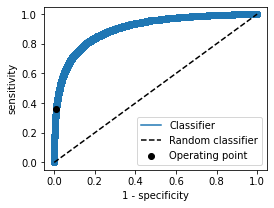

In [0]:
results_train_xgb_9505, results_test_xgb_9505, \
y_pred_prob_train_xgb_9505, y_pred_prob_test_xgb_9505 = model_evaluation2(xgb_9505, 
                                                                          X_9505, y_9505,
                                                                          X_test.values, y_test.values,
                                                                          print_ = 1)

### Save results to dataframe

In [0]:
xgb_results_train = xgb_results_train.append(results_train_xgb_9505.rename(index={results_train_xgb_9505.index[-1]: 'XGB 95/05 Ratio All features'}))
xgb_results_test = xgb_results_test.append(results_test_xgb_9505.rename(index={results_test_xgb_9505.index[-1]: 'XGB 95/05 Ratio All features'}))

# 95/05 Ratio: Feature selection

In [0]:
# create the model/estimator
xgb_9505_rfe = XGBClassifier(booster='gbtree',
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective='binary:logistic',
                             nthread=-1,
                             seed=seed,
                             learning_rate=0.1,
                             max_depth=10,
                             min_child_weight=1,
                             n_estimators=1000)

### Use the selected features for 95/05 dataset

In [0]:
X_9505_rfe, y_9505_rfe = ratio9505.fit_resample(X_all.loc[:, rfe_feat], y_all)

### Model

In [0]:
start = datetime.now()

xgb_9505_rfe.fit(X_9505_rfe, y_9505_rfe)

print('Training took: ', datetime.now()-start)

Training took:  0:02:33.700391


### Model Performance

TRAINING SET
Threshold: 0.3
TP: 20096
TN: 382062
FP: 9
FN: 13
Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall (Detection rate): 1.0
F1-score: 1.0
AUC: 1.0
FPR (False alarm rate): 0.0
FNR: 0.0
Kappa: 1.0


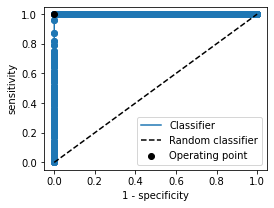

TEST SET
Threshold: 0.3
TP: 3146
TN: 264709
FP: 370
FN: 1881
Accuracy: 0.99
Sensitivity: 0.63
Specificity: 1.0
Precision: 0.89
Recall (Detection rate): 0.63
F1-score: 0.77
AUC: 0.98
FPR (False alarm rate): 0.0
FNR: 0.37
Kappa: 0.73


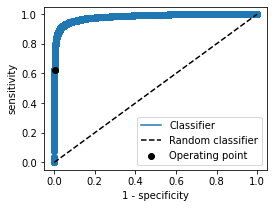

In [0]:
results_train_xgb_9505_rfe, results_test_xgb_9505_rfe, \
y_pred_prob_train_xgb_9505_rfe, y_pred_prob_test_xgb_9505_rfe = model_evaluation2(xgb_9505_rfe, 
                                                                                  X_9505_rfe, y_9505_rfe,
                                                                                  X_test.loc[:, rfe_feat].values, y_test.values,
                                                                                  print_ = 1)

### Save results to dataframe

In [0]:
xgb_results_train = xgb_results_train.append(results_train_xgb_9505_rfe.rename(index={results_train_xgb_9505_rfe.index[-1]: 'XGB 95/05 Ratio with Feature Selection'}))
xgb_results_test = xgb_results_test.append(results_test_xgb_9505_rfe.rename(index={results_test_xgb_9505_rfe.index[-1]: 'XGB 95/05 Ratio with Feature Selection'}))

# 98/02 Ratio: All features

In [0]:
grid_xgb_uds.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1}

In [0]:
# create the model/estimator
xgb_9802 = XGBClassifier(booster='gbtree',
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective='binary:logistic',
                         nthread=-1,
                         seed=seed,
                         learning_rate=0.1,
                         max_depth=10,
                         min_child_weight=1,
                         n_estimators=1000)

In [0]:
start = datetime.now()

xgb_9802.fit(X_all, y_all)

print('Training took: ', datetime.now()-start)

Training took:  0:09:41.529923


### Performance on training and test set

TRAINING SET
Threshold: 0.12
TP: 18330
TN: 1059675
FP: 640
FN: 1779
Accuracy: 1.0
Sensitivity: 0.91
Specificity: 1.0
Precision: 0.97
Recall (Detection rate): 0.91
F1-score: 0.94
AUC: 1.0
FPR (False alarm rate): 0.0
FNR: 0.09
Kappa: 0.94


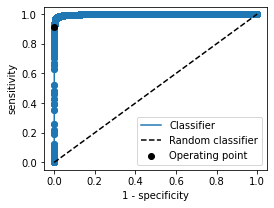

TEST SET
Threshold: 0.12
TP: 1510
TN: 264478
FP: 601
FN: 3517
Accuracy: 0.98
Sensitivity: 0.3
Specificity: 1.0
Precision: 0.72
Recall (Detection rate): 0.3
F1-score: 0.46
AUC: 0.91
FPR (False alarm rate): 0.0
FNR: 0.7
Kappa: 0.42


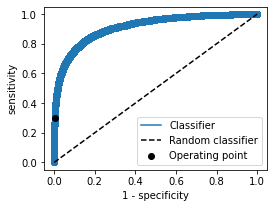

In [0]:
results_train_xgb_9802, results_test_xgb_9802, \
y_pred_prob_train_xgb_9802, y_pred_prob_test_xgb_9802 = model_evaluation2(xgb_9802, 
                                                                          X_all, y_all,
                                                                          X_test, y_test,
                                                                          print_ = 1)

### Save results to dataframe

In [0]:
xgb_results_train = xgb_results_train.append(results_train_xgb_9802.rename(index={results_train_xgb_9802.index[-1]: 'XGB 98/02 Ratio All features'}))
xgb_results_test = xgb_results_test.append(results_test_xgb_9802.rename(index={results_test_xgb_9802.index[-1]: 'XGB 98/02 Ratio All features'}))

# 98/02 Ratio: Feature selection

In [0]:
# create the model/estimator
xgb_9802_rfe = XGBClassifier(booster='gbtree',
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective='binary:logistic',
                             nthread=-1,
                             seed=seed,
                             learning_rate=0.1,
                             max_depth=10,
                             min_child_weight=1,
                             n_estimators=1000)

### Use the selected features for 98/02 dataset

In [0]:
X_9802_rfe, y_9802_rfe = X_all.loc[:, rfe_feat], y_all

### Model

In [0]:
start = datetime.now()

xgb_9802_rfe.fit(X_9802_rfe, y_9802_rfe)

print('Training took: ', datetime.now()-start)

Training took:  0:06:44.158436


### Model Performance

TRAINING SET
Threshold: 0.26
TP: 20062
TN: 1060282
FP: 33
FN: 47
Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall (Detection rate): 1.0
F1-score: 1.0
AUC: 1.0
FPR (False alarm rate): 0.0
FNR: 0.0
Kappa: 1.0


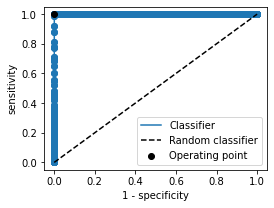

TEST SET
Threshold: 0.26
TP: 2702
TN: 264969
FP: 110
FN: 2325
Accuracy: 0.99
Sensitivity: 0.54
Specificity: 1.0
Precision: 0.96
Recall (Detection rate): 0.54
F1-score: 0.81
AUC: 0.99
FPR (False alarm rate): 0.0
FNR: 0.46
Kappa: 0.69


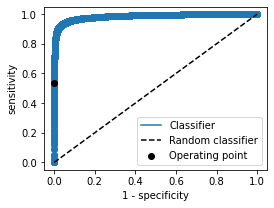

In [0]:
results_train_xgb_9802_rfe, results_test_xgb_9802_rfe, \
y_pred_prob_train_xgb_9802_rfe, y_pred_prob_test_xgb_9802_rfe = model_evaluation2(xgb_9802_rfe, 
                                                                                  X_9802_rfe, y_9802_rfe,
                                                                                  X_test.loc[:, rfe_feat], y_test,
                                                                                  print_ = 1)

### Save results to dataframe

In [0]:
xgb_results_train = xgb_results_train.append(results_train_xgb_9802_rfe.rename(index={results_train_xgb_9802_rfe.index[-1]: 'XGB 98/02 Ratio with Feature Selection'}))
xgb_results_test = xgb_results_test.append(results_test_xgb_9802_rfe.rename(index={results_test_xgb_9802_rfe.index[-1]: 'XGB 98/02 Ratio with Feature Selection'}))

### Save the training and test dataframes to csv files

In [0]:
xgb_results_train.to_csv('XGB_Train_Results.csv', index=True)
xgb_results_test.to_csv('XGB_Test_Results.csv', index=True)

### Save the best XGBoost model (model with highest F1-score on test set)

In [0]:
print('Best model: ', xgb_results_test.sort_values(by='F1', axis=0, ascending=False).index[0])

Best model:  XGB 98/02 Ratio with Feature Selection
